# Introduction: Forecasting of Attraction Wait Times using Time series analysis with lagging function


###### Components of a Time-Series
###### Trend - The trend shows a general direction of the time series data over a long period of time. A  trend can be increasing(upward), decreasing(downward), or horizontal(stationary).
###### Seasonality - The seasonality component exhibits a trend that repeats with respect to timing, direction, and magnitude. Some examples include an increase in water consumption in summer due to hot weather conditions.
###### Cyclical Component - These are the trends with no set repetition over a particular period of time. A cycle refers to the period of ups and downs, booms and slums of a time series, mostly observed in business cycles. These cycles do not exhibit a seasonal variation but generally occur over a time period of 3 to 12 years depending on the nature of the time series.
###### Irregular Variation - These are the fluctuations in the time series data which become evident when trend and cyclical variations are removed. These variations are unpredictable, erratic, and may or may not be random.
###### ETS Decomposition - ETS Decomposition is used to separate different components of a time series. The term ETS stands for Error, Trend and Seasonality.

## SETUP: IMPORT LIBRARIES


In [422]:
import sys
import os
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,median_absolute_error,mean_absolute_percentage_error

# Configure visualization styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.autolayout'] = True
warnings.filterwarnings('ignore')

## Get the Data

#### Jupyter notebook 'merge_df' was used to complie waiting times data for 15 attractions for past 3 years.

In [363]:
df = pd.read_csv('ARTHUR_Queue_Times_By_Date_Time.csv')
print("Dataset 'ARTHUR_Queue_Times_By_Date_Time.csv' loaded successfully.")

Dataset 'ARTHUR_Queue_Times_By_Date_Time.csv' loaded successfully.


In [364]:
park_open_hrs = pd.read_csv('park_open_hours.csv')

In [365]:
park_open_hrs.head()

,Unnamed: 0,ARTHUR_WaitTime,Month,Year,Date,Time,temperature_in_celsius,precipitation_in_percent,wind_speed_in_kmh,Is_School_Holiday,Is_Public_Holiday,Park_Open
0,9,1.0,April,2022,2022-04-01,09:00,NaN,NaN,NaN,0,0,1
1,10,1.0,April,2022,2022-04-01,09:05,NaN,NaN,NaN,0,0,1
2,11,1.0,April,2022,2022-04-01,09:10,NaN,NaN,NaN,0,0,1
3,12,1.0,April,2022,2022-04-01,09:15,NaN,NaN,NaN,0,0,1
4,13,1.0,April,2022,2022-04-01,09:20,NaN,NaN,NaN,0,0,1


In [366]:
df.head()

,Unnamed: 0,ARTHUR_WaitTime,Month,Year,Date,Time,temperature_in_celsius,precipitation_in_percent,wind_speed_in_kmh
0,0,-4.0,April,2022,2022-04-01,08:15,NaN,NaN,NaN
1,1,-4.0,April,2022,2022-04-01,08:20,NaN,NaN,NaN
2,2,-4.0,April,2022,2022-04-01,08:25,NaN,NaN,NaN
3,3,-4.0,April,2022,2022-04-01,08:30,NaN,NaN,NaN
4,4,-4.0,April,2022,2022-04-01,08:35,NaN,NaN,NaN


In [367]:
df.isna().sum()

Unnamed: 0                      0
ARTHUR_WaitTime              2336
Month                           0
Year                            0
Date                            0
Time                          836
temperature_in_celsius      85828
precipitation_in_percent    85828
wind_speed_in_kmh           85828
dtype: int64

In [368]:
df.describe()

,Unnamed: 0,ARTHUR_WaitTime,Year,temperature_in_celsius,precipitation_in_percent,wind_speed_in_kmh
count,549604.000000,547268.000000,549604.000000,463776.000000,463776.000000,463776.000000
mean,274801.500000,24.365812,2023.231501,15.718453,26.695064,13.889572
std,158657.153011,15.866329,0.888536,7.772595,19.392560,11.390221
min,0.000000,-4.000000,2022.000000,-8.100000,0.000000,5.000000
25%,137400.750000,15.000000,2023.000000,10.200000,10.000000,5.000000
50%,274801.500000,25.000000,2023.000000,15.600000,30.000000,10.000000
75%,412202.250000,35.000000,2024.000000,21.600000,30.000000,15.000000
max,549603.000000,91.000000,2025.000000,36.300000,95.000000,70.000000


## Data Understanding and Cleaning

In [369]:
# Combine 'Date' and 'Time' into a single, proper datetime object for time series analysis.
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
# Sort the DataFrame chronologically to ensure the integrity of time-based operations.
df = df.sort_values(by='DateTime')

# Define the primary target variable for our analysis.
TARGET = 'ARTHUR_WaitTime'

In [370]:
# Drop redundant index columns that might exist from previous saves.
cols_to_drop = [col for col in df.columns if 'Unnamed: 0' in col] 
df = df.drop(columns=cols_to_drop)
park_open_hrs = park_open_hrs.drop(columns=cols_to_drop)

In [371]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
print("\nStandardized Column Names:")
print(df.columns)


Standardized Column Names:
Index(['arthur_waittime', 'month', 'year', 'date', 'time',
       'temperature_in_celsius', 'precipitation_in_percent',
       'wind_speed_in_kmh', 'datetime'],
      dtype='object')


In [372]:
DATE_COL = 'datetime'
QUEUE_TIME_COL = 'arthur_waittime'
print(df.isnull().sum())

arthur_waittime              2336
month                           0
year                            0
date                            0
time                          836
temperature_in_celsius      85828
precipitation_in_percent    85828
wind_speed_in_kmh           85828
datetime                      836
dtype: int64


In [373]:
# Drop rows where the date or queue time is missing, as they are essential for analysis
df.dropna(subset=[DATE_COL, QUEUE_TIME_COL], inplace=True)
print(df.isnull().sum())



arthur_waittime                 0
month                           0
year                            0
date                            0
time                            0
temperature_in_celsius      84992
precipitation_in_percent    84992
wind_speed_in_kmh           84992
datetime                        0
dtype: int64


In [374]:
# Handling Duplicates 
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Duplicate rows removed. Current shape: {df.shape}")


Number of duplicate rows: 36
Duplicate rows removed. Current shape: (547232, 9)


In [375]:
# Creating features from waiting time columns according to available legends on source
df['status_open'] = (df['arthur_waittime'] == 0).astype(int)
df['status_virtual_queue'] = (df['arthur_waittime'] == -1).astype(int)
df['status_maintenance'] = (df['arthur_waittime'] == -2).astype(int)
df['status_closed_weather'] = (df['arthur_waittime'] == -3).astype(int)
df['status_attraction_closed'] = (df['arthur_waittime'] == -4).astype(int)
df['status_over_90_min'] = (df['arthur_waittime'] == 91).astype(int)

In [376]:
TARGET = 'arthur_waittime'
df.loc[df[TARGET] < 0, TARGET] = np.nan

In [377]:
# Impute missing values using forward-fill followed by backward-fill.
# This ensures that gaps are filled with the most recent valid observation, which is a
# reasonable assumption for slowly changing data like weather and wait times.

print("Imputing missing values for target and weather features...")
df[TARGET] = df[TARGET].ffill().bfill()
weather_features = ['temperature_in_celsius', 'precipitation_in_percent', 'wind_speed_in_kmh']
df[weather_features] = df[weather_features].ffill().bfill()

Imputing missing values for target and weather features...


In [378]:
print(df.isnull().sum())

arthur_waittime             0
month                       0
year                        0
date                        0
time                        0
temperature_in_celsius      0
precipitation_in_percent    0
wind_speed_in_kmh           0
datetime                    0
status_open                 0
status_virtual_queue        0
status_maintenance          0
status_closed_weather       0
status_attraction_closed    0
status_over_90_min          0
dtype: int64


In [379]:
# Extract useful features from the datetime column
df['year'] = df[DATE_COL].dt.year
df['month'] = df[DATE_COL].dt.month_name()
df['day'] = df[DATE_COL].dt.day
df['hour'] = df[DATE_COL].dt.hour
df['day_of_week'] = df[DATE_COL].dt.day_name()
df['week_of_year'] = df[DATE_COL].dt.isocalendar().week.astype(int)
df['is_weekend'] = df[DATE_COL].dt.dayofweek.isin([5, 6]).astype(int) # 5: Saturday, 6: Sunday

print("New time-based features created:")
print(df[['year', 'month', 'day', 'hour', 'day_of_week', 'is_weekend']].head())

New time-based features created:
   year  month  day  hour day_of_week  is_weekend
0  2022  April    1     8      Friday           0
1  2022  April    1     8      Friday           0
2  2022  April    1     8      Friday           0
3  2022  April    1     8      Friday           0
4  2022  April    1     8      Friday           0


## Exploratory Data Analysis

In [380]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547232 entries, 0 to 534650
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   arthur_waittime           547232 non-null  float64       
 1   month                     547232 non-null  object        
 2   year                      547232 non-null  int64         
 3   date                      547232 non-null  object        
 4   time                      547232 non-null  object        
 5   temperature_in_celsius    547232 non-null  float64       
 6   precipitation_in_percent  547232 non-null  float64       
 7   wind_speed_in_kmh         547232 non-null  float64       
 8   datetime                  547232 non-null  datetime64[ns]
 9   status_open               547232 non-null  int32         
 10  status_virtual_queue      547232 non-null  int32         
 11  status_maintenance        547232 non-null  int32         
 12  st

In [381]:
# DESCRIPTIVE STATISTICS

print(f"\nDescriptive statistics for '{QUEUE_TIME_COL}':")
print(df[QUEUE_TIME_COL].describe())


Descriptive statistics for 'arthur_waittime':
count    547232.000000
mean         26.245178
std          13.884493
min           0.000000
25%          20.000000
50%          25.000000
75%          35.000000
max          91.000000
Name: arthur_waittime, dtype: float64


### Univariant analysis of attraction

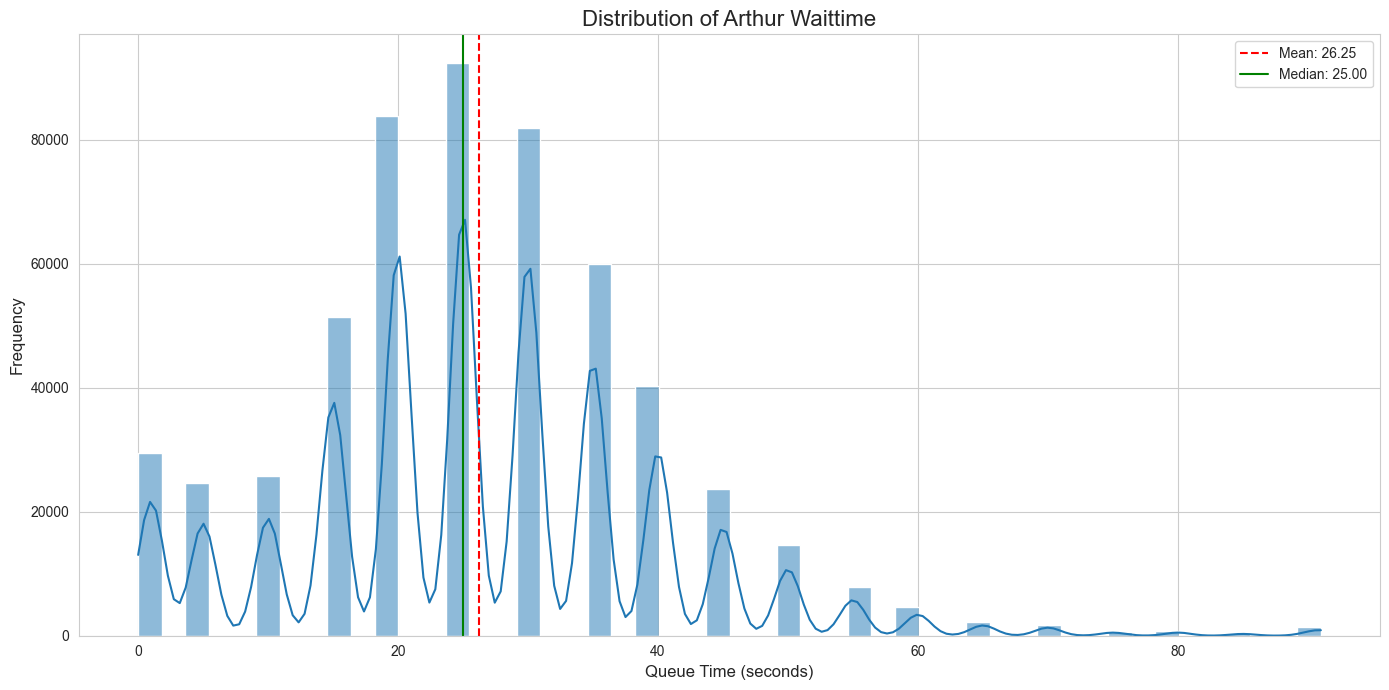

In [382]:
# Distribution of Queue Times
plt.figure(figsize=(14, 7))
sns.histplot(df[QUEUE_TIME_COL], kde=True, bins=50)
plt.title(f'Distribution of {QUEUE_TIME_COL.replace("_", " ").title()}', fontsize=16)
plt.xlabel('Queue Time (seconds)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(df[QUEUE_TIME_COL].mean(), color='red', linestyle='--', label=f'Mean: {df[QUEUE_TIME_COL].mean():.2f}')
plt.axvline(df[QUEUE_TIME_COL].median(), color='green', linestyle='-', label=f'Median: {df[QUEUE_TIME_COL].median():.2f}')
plt.legend()
plt.show()

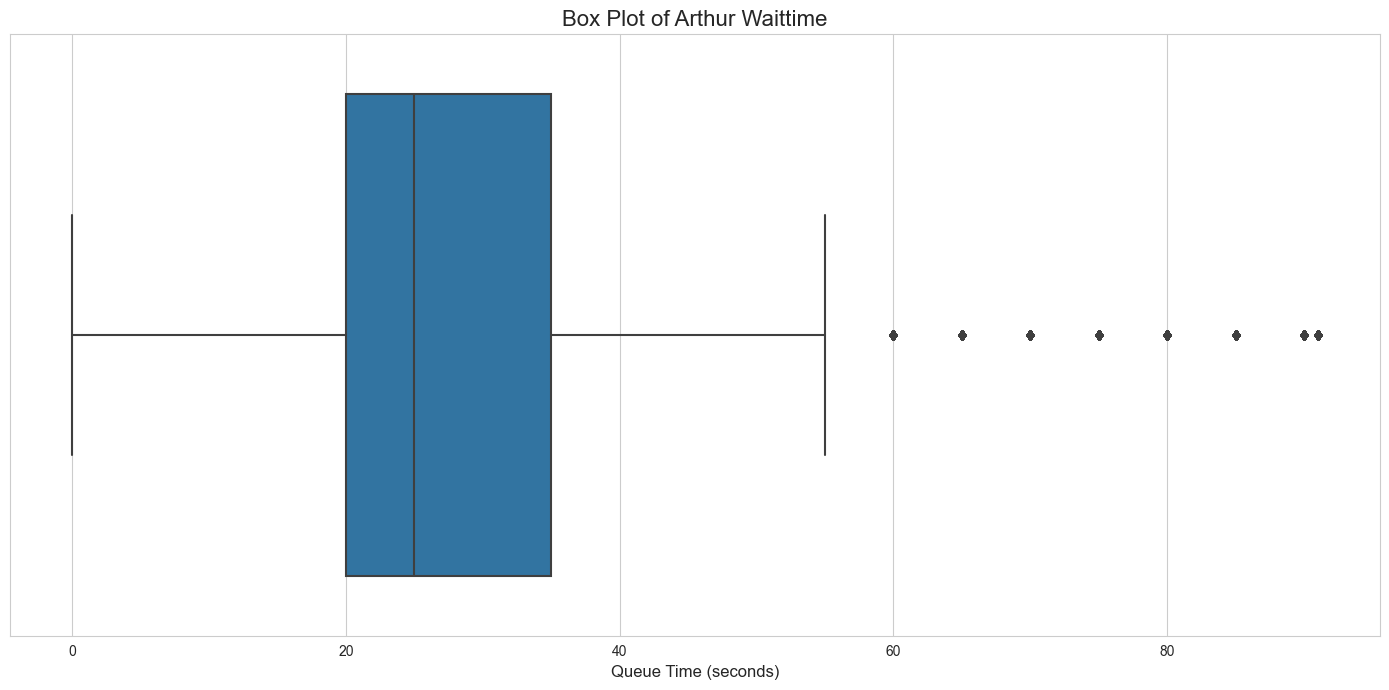

In [383]:
# Box Plot of Queue Times to Identify Outliers
plt.figure(figsize=(14, 7))
sns.boxplot(x=df[QUEUE_TIME_COL])
plt.title(f'Box Plot of {QUEUE_TIME_COL.replace("_", " ").title()}', fontsize=16)
plt.xlabel('Queue Time (seconds)', fontsize=12)
plt.show()

### Bi-Variant analysis


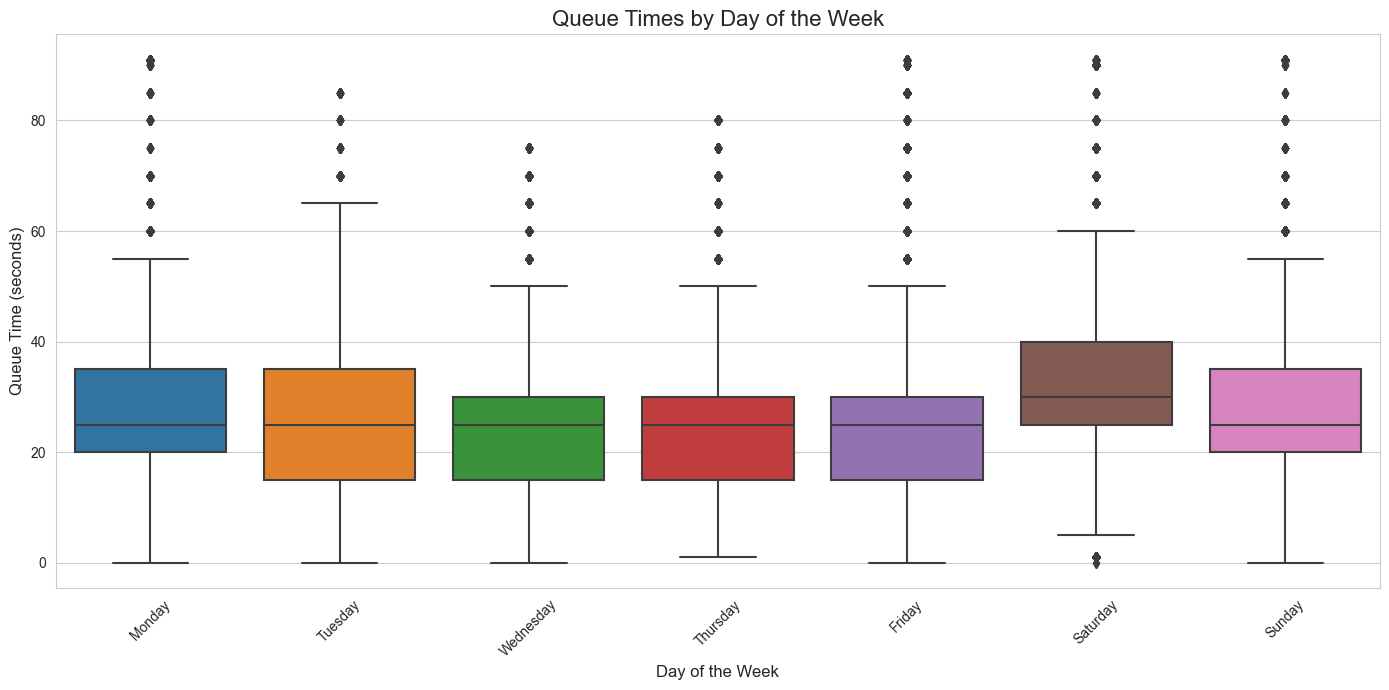

In [384]:
# Queue Times by Day of the Week
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.figure(figsize=(14, 7))
sns.boxplot(data=df, x='day_of_week', y=QUEUE_TIME_COL, order=day_order)
plt.title('Queue Times by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Queue Time (seconds)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

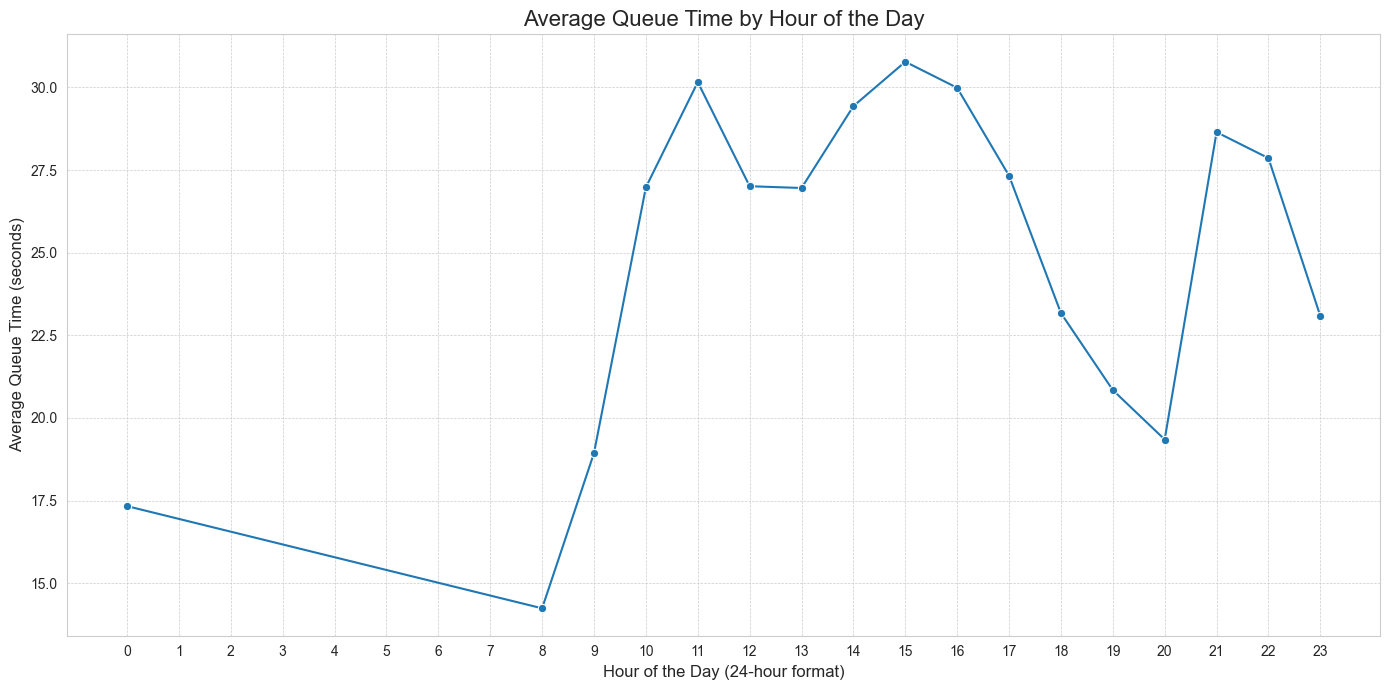

In [385]:
# Queue Times by Hour of the Day
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='hour', y=QUEUE_TIME_COL, ci=None, estimator='mean', marker='o')
plt.title('Average Queue Time by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day (24-hour format)', fontsize=12)
plt.ylabel('Average Queue Time (seconds)', fontsize=12)
plt.xticks(np.arange(0, 24, 1))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

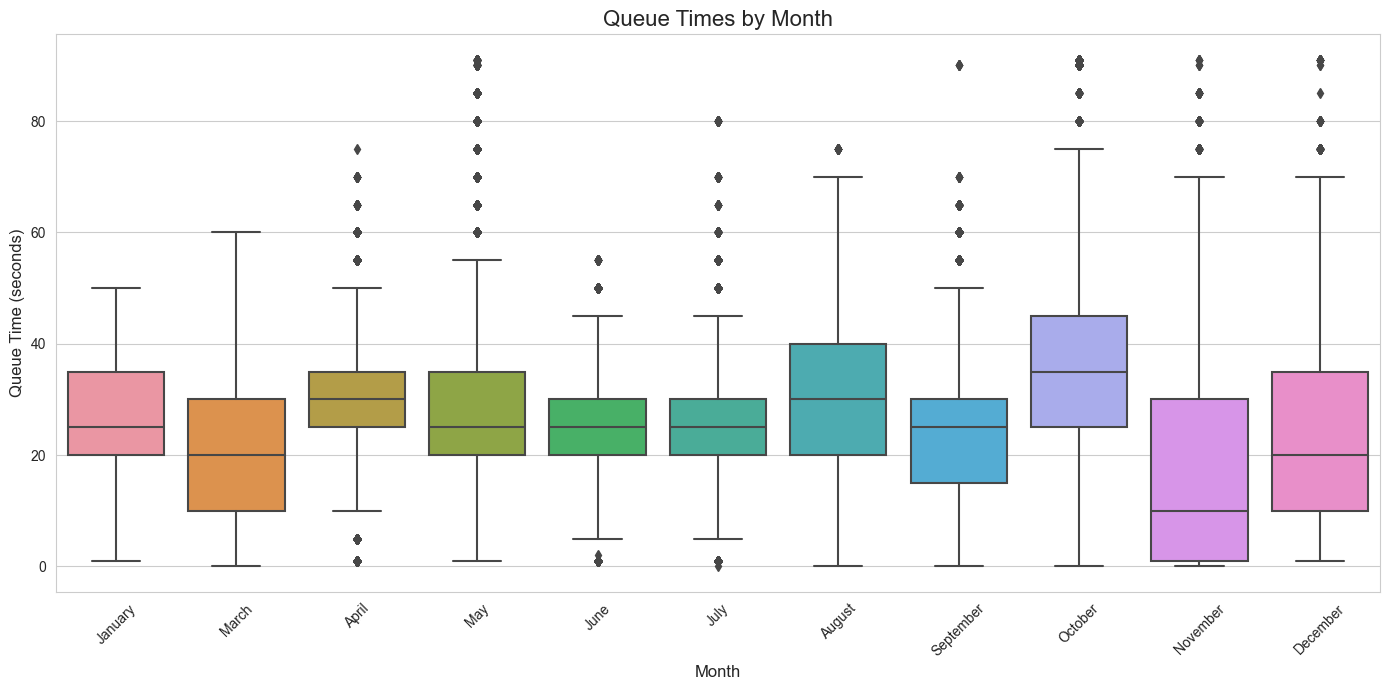

In [386]:
# Queue Times by Month
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# Filter months present in the data
available_months = [m for m in month_order if m in df['month'].unique()]
plt.figure(figsize=(14, 7))
sns.boxplot(data=df, x='month', y=QUEUE_TIME_COL, order=available_months)
plt.title('Queue Times by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Queue Time (seconds)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

### Time-Series Analysis

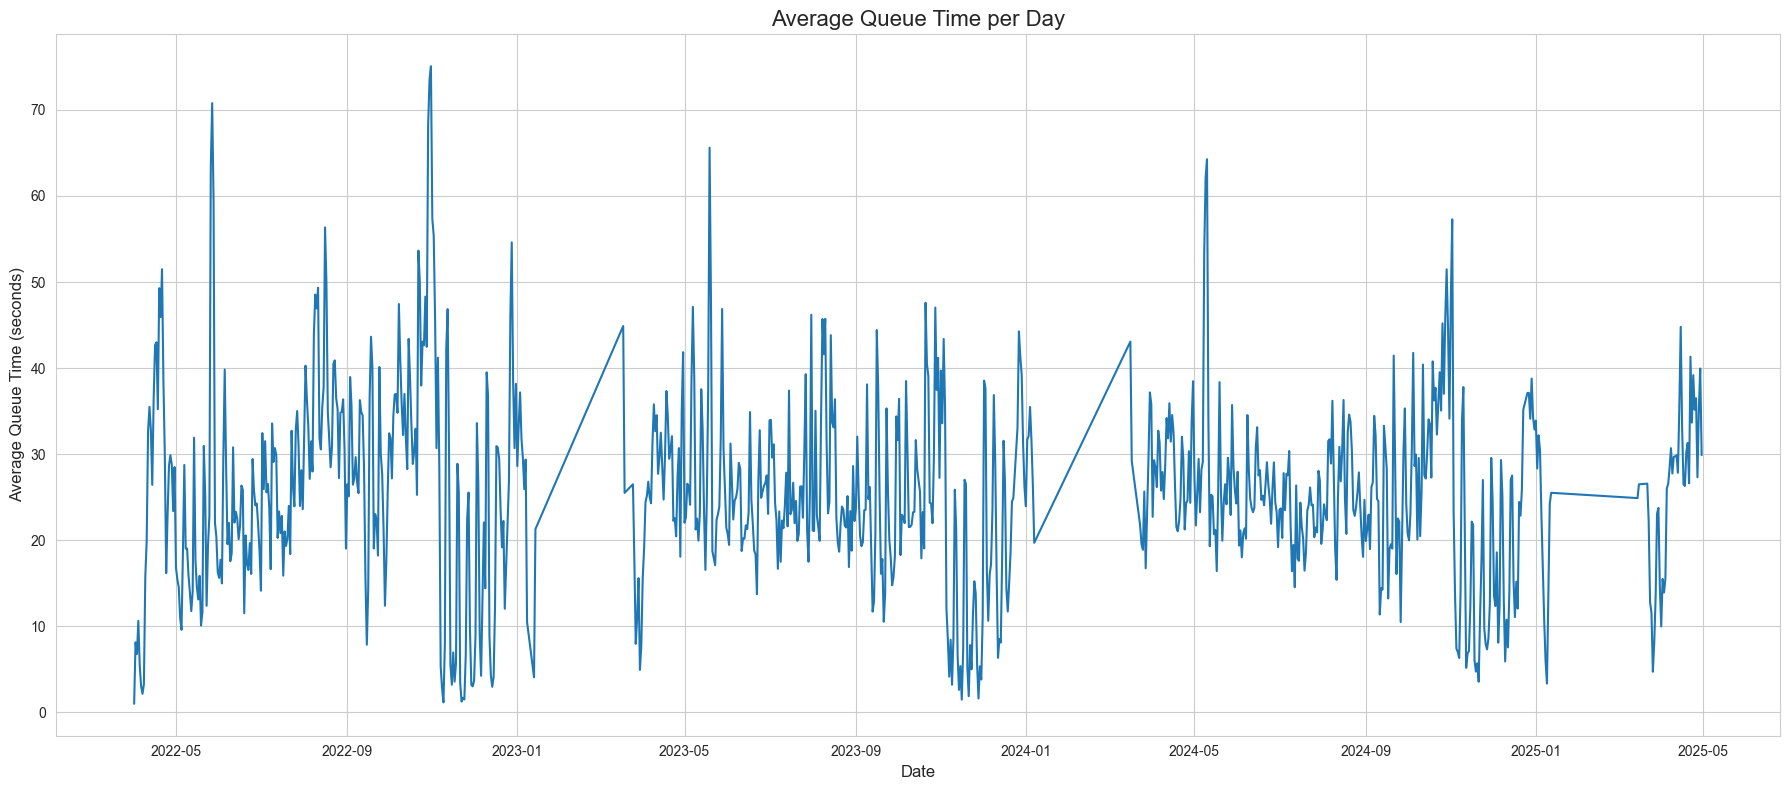

In [387]:
# Average Queue Time Over Time (Daily)
daily_avg = df.groupby('date')[QUEUE_TIME_COL].mean().reset_index()
daily_avg['date'] = pd.to_datetime(daily_avg['date'])

plt.figure(figsize=(18, 8))
plt.plot(daily_avg['date'], daily_avg[QUEUE_TIME_COL])
plt.title('Average Queue Time per Day', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Queue Time (seconds)', fontsize=12)
plt.show()

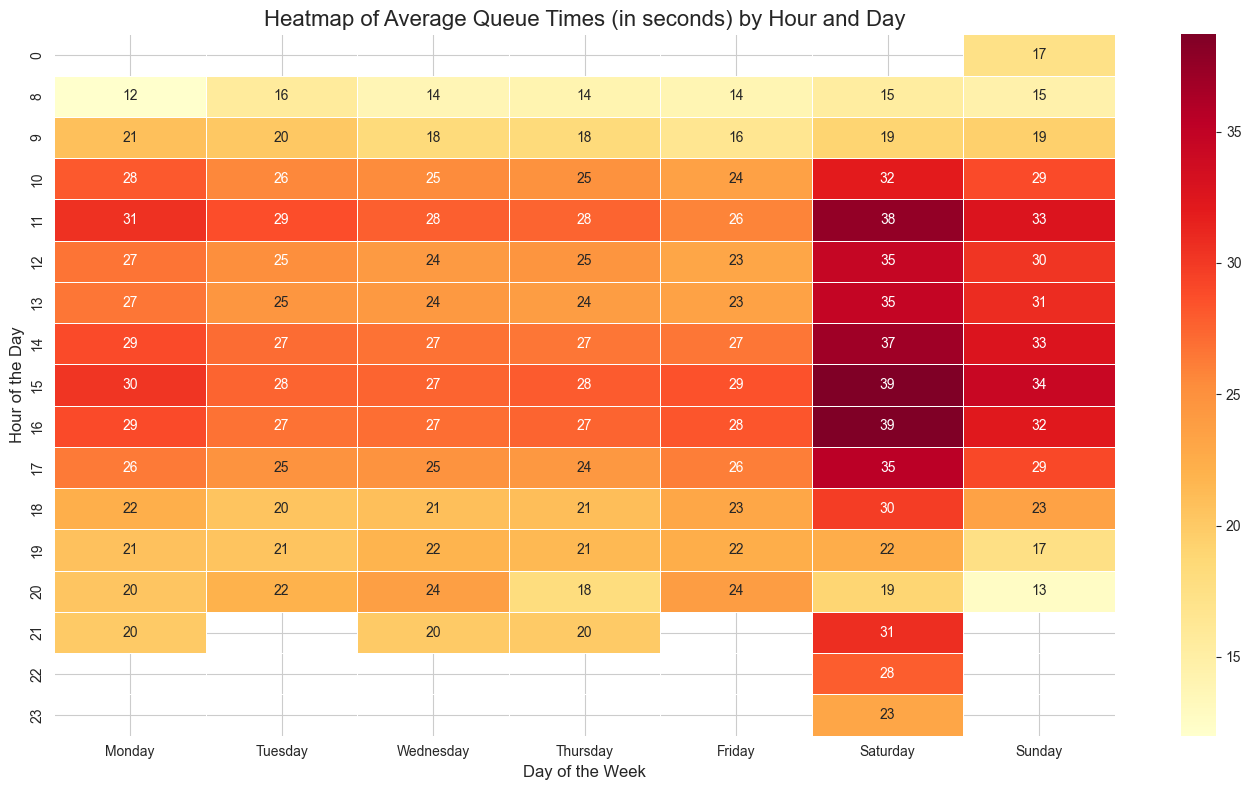

In [388]:
# Heatmap of Queue Times by Day and Hour
# Pivot table to structure data for heatmap
pivot_table = df.pivot_table(values=QUEUE_TIME_COL, index='hour', columns='day_of_week', aggfunc='mean')
pivot_table = pivot_table.reindex(columns=day_order) # Order columns by day of the week

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt=".0f", linewidths=.5)
plt.title('Heatmap of Average Queue Times (in seconds) by Hour and Day', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Hour of the Day', fontsize=12)
plt.show()

### Multivariant analysis

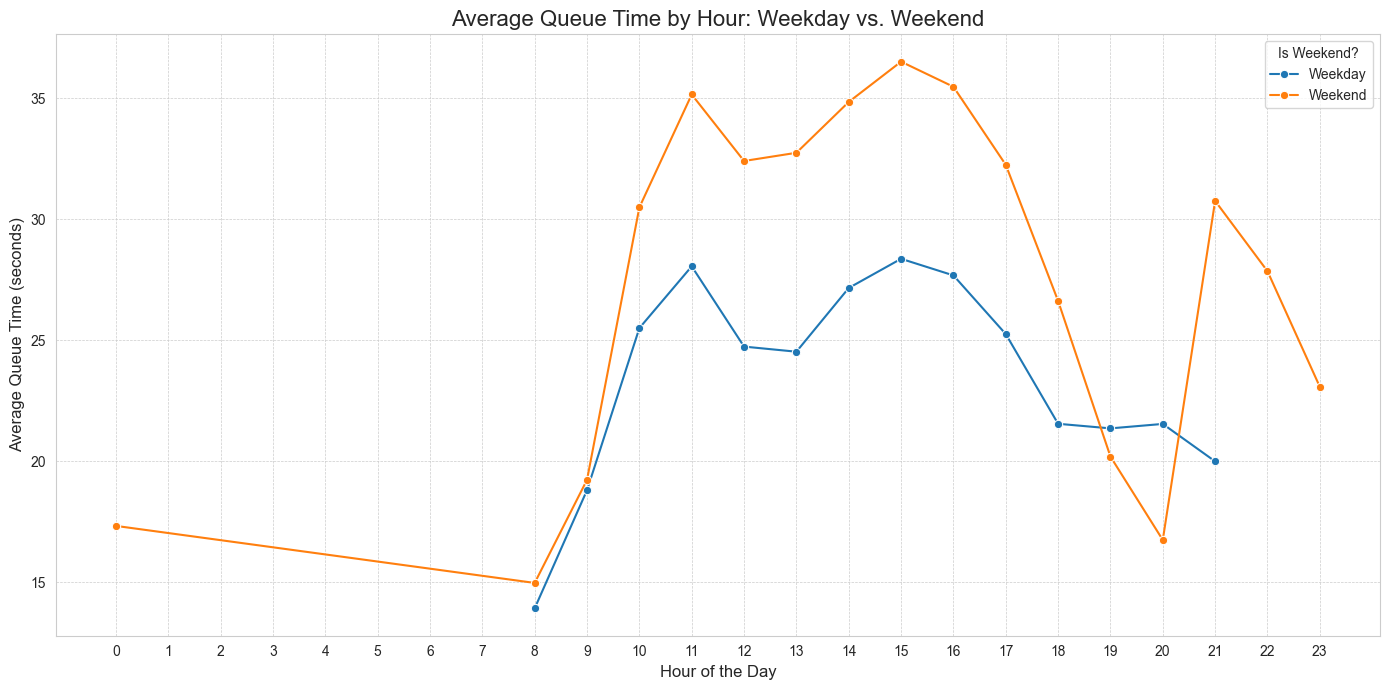

In [389]:
# Comparing Weekend vs. Weekday patterns by hour
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='hour', y=QUEUE_TIME_COL, hue='is_weekend', ci=None, estimator='mean', marker='o')
plt.title('Average Queue Time by Hour: Weekday vs. Weekend', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average Queue Time (seconds)', fontsize=12)
plt.xticks(np.arange(0, 24, 1))
plt.legend(title='Is Weekend?', labels=['Weekday', 'Weekend'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

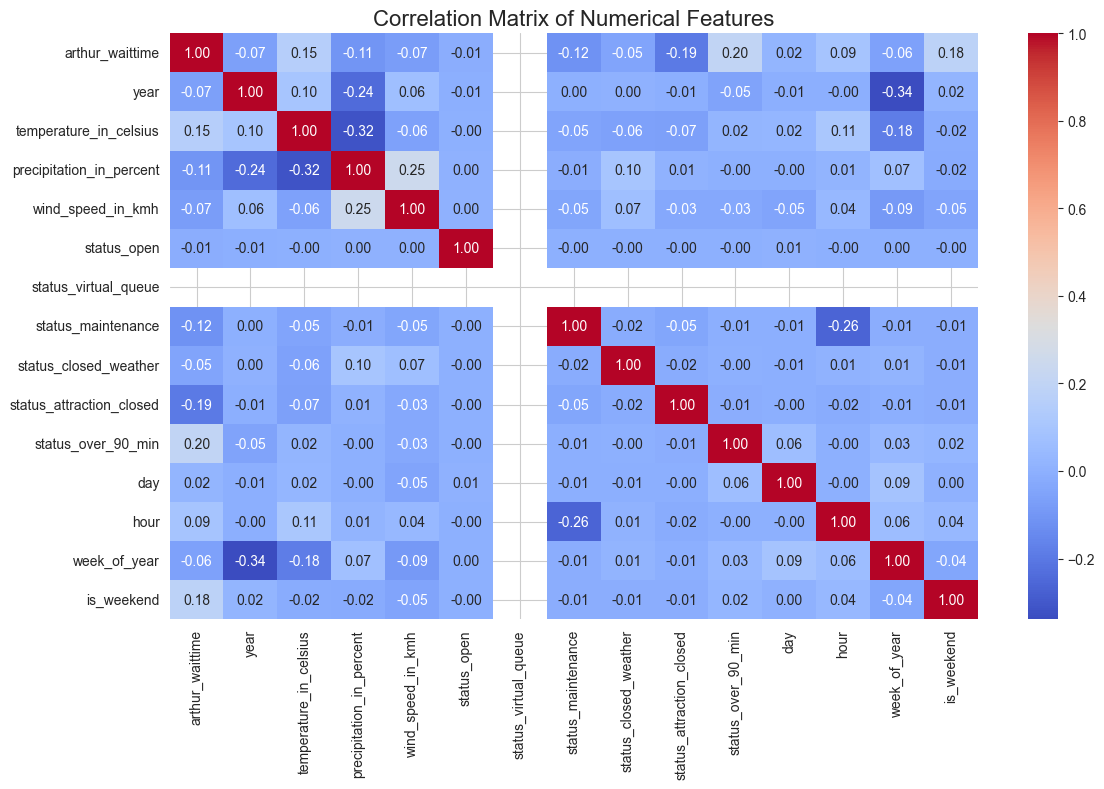

In [390]:
# Correlation Matrix 
numerical_cols = df.select_dtypes(include=np.number)
correlation_matrix = numerical_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

### Weather feature analysis with attraction waititng times


Plot 6: Analyzing the relationship between temperature and wait times...


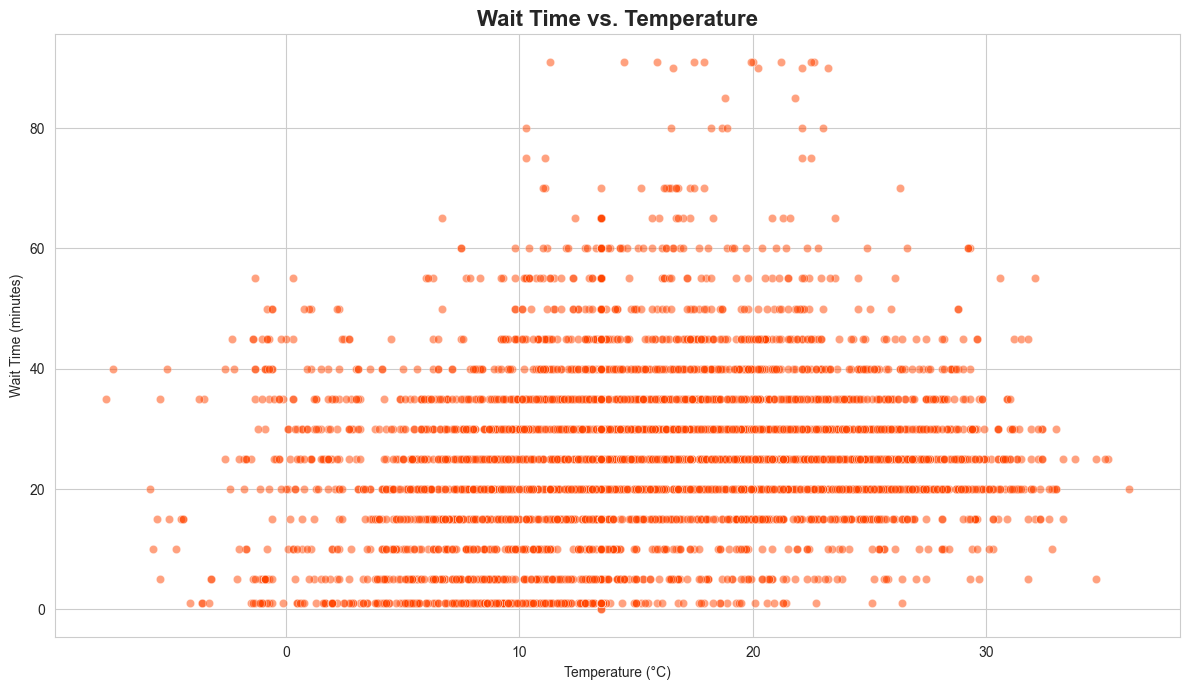

Insight: There does not appear to be a strong linear relationship. However, the longest wait times tend to occur during moderate temperatures (10-25°C), suggesting that very hot or very cold weather might deter park attendance.


In [391]:
# Temperature vs. Wait Time
print("\nPlot 6: Analyzing the relationship between temperature and wait times...")
plt.figure(figsize=(12, 7))
sns.scatterplot(x='temperature_in_celsius', y=TARGET, data=df.sample(5000), alpha=0.5, color='orangered')
plt.title('Wait Time vs. Temperature', fontsize=16, weight='bold')
plt.xlabel('Temperature (°C)')
plt.ylabel('Wait Time (minutes)')
plt.tight_layout()
plt.show()
print("Insight: There does not appear to be a strong linear relationship. However, the longest wait times tend to occur during moderate temperatures (10-25°C), suggesting that very hot or very cold weather might deter park attendance.")



Analyzing the relationship between precipitation and wait times...


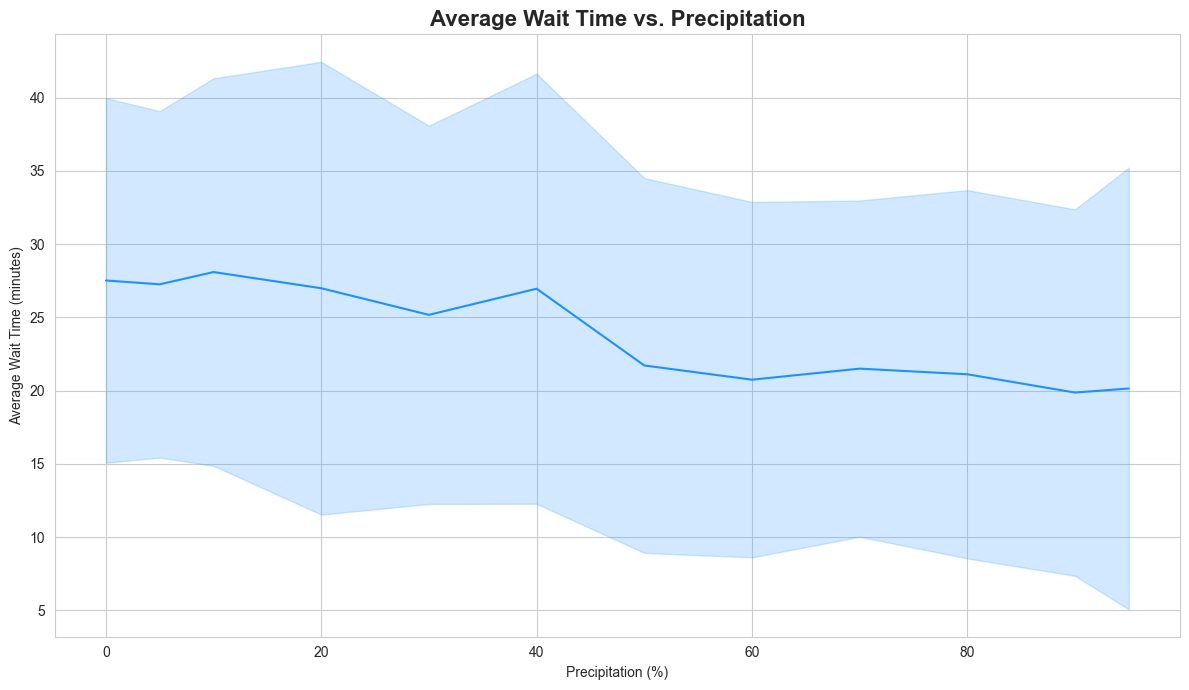

In [392]:
print("\nAnalyzing the relationship between precipitation and wait times...")
plt.figure(figsize=(12, 7))
sns.lineplot(x='precipitation_in_percent', y=TARGET, data=df, color='dodgerblue', estimator='mean', errorbar='sd')
plt.title('Average Wait Time vs. Precipitation', fontsize=16, weight='bold')
plt.xlabel('Precipitation (%)')
plt.ylabel('Average Wait Time (minutes)')
plt.tight_layout()
plt.show()


Analyzing the relationship between wind speed and wait times...


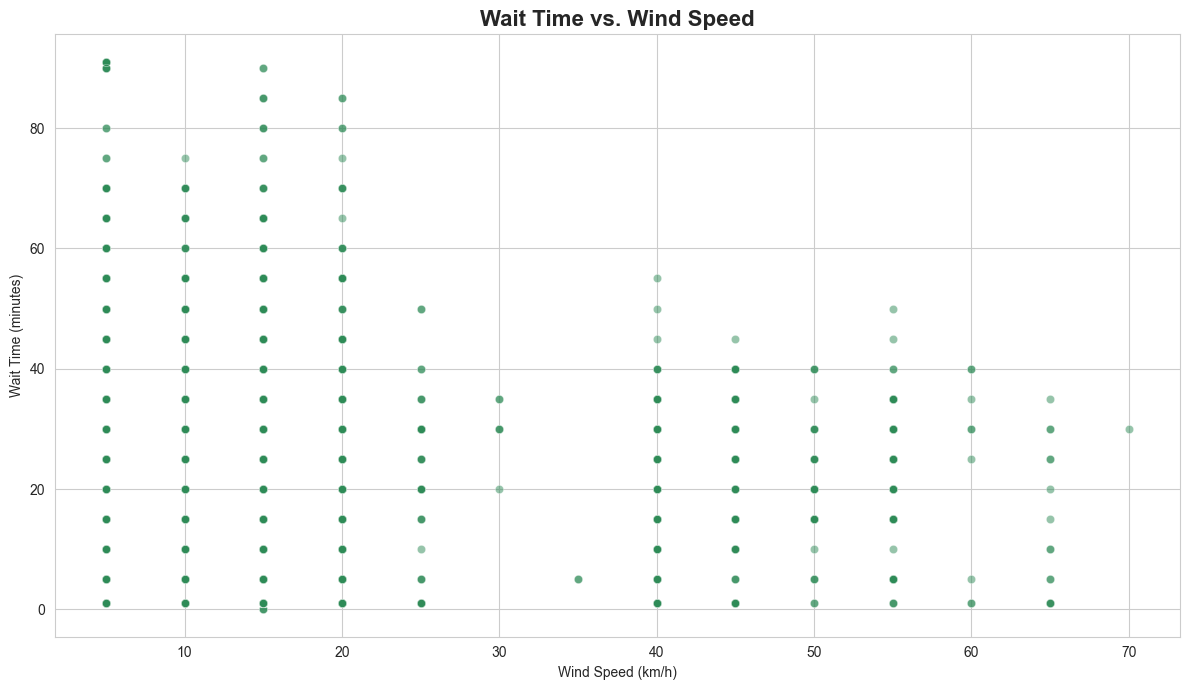

In [393]:
print("\nAnalyzing the relationship between wind speed and wait times...")
plt.figure(figsize=(12, 7))
sns.scatterplot(x='wind_speed_in_kmh', y=TARGET, data=df.sample(5000), alpha=0.5, color='seagreen')
plt.title('Wait Time vs. Wind Speed', fontsize=16, weight='bold')
plt.xlabel('Wind Speed (km/h)')
plt.ylabel('Wait Time (minutes)')
plt.tight_layout()
plt.show()


Investigating seasonal patterns by comparing wait times across months...


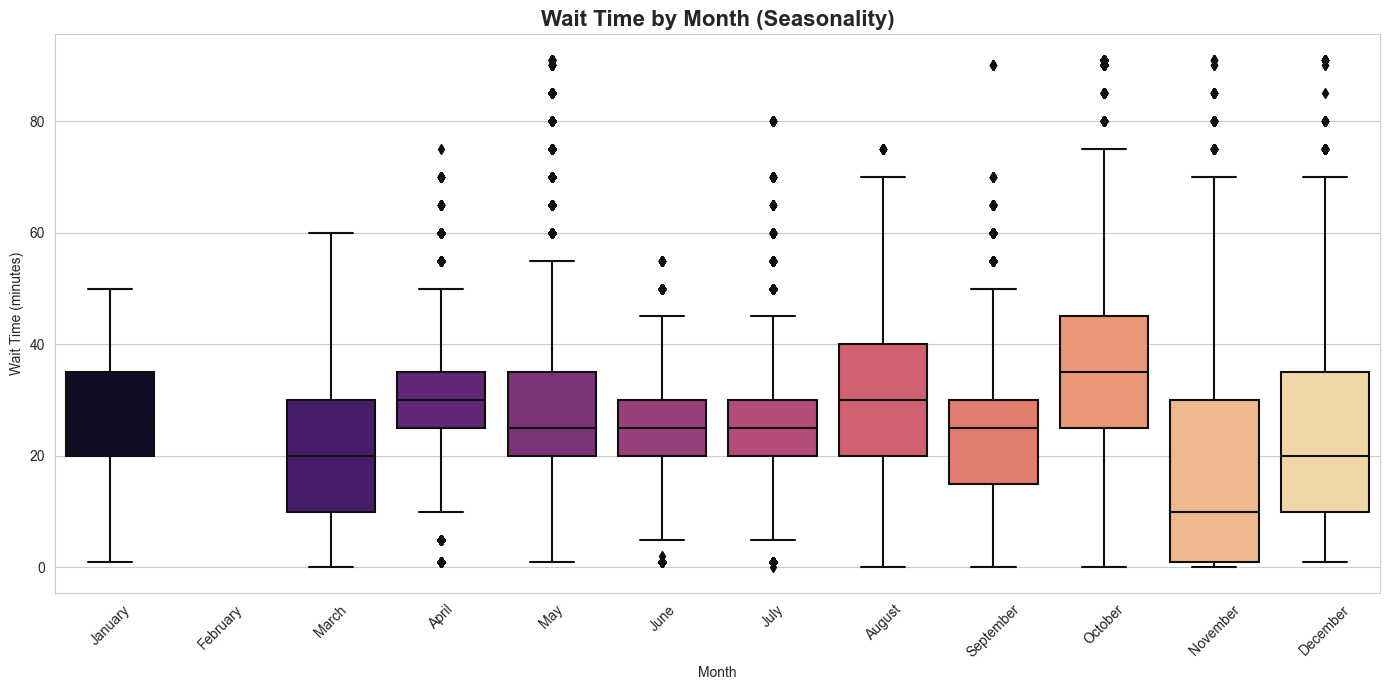

In [394]:
# Seasonality - Wait Times by Month
# FIX: Using month names directly for plotting to avoid potential library errors.
month_order_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
print("\nInvestigating seasonal patterns by comparing wait times across months...")
plt.figure(figsize=(14, 7))
sns.boxplot(x='month', y=TARGET, data=df, palette='magma', order=month_order_names)
plt.title('Wait Time by Month (Seasonality)', fontsize=16, weight='bold')
plt.xlabel('Month')
plt.ylabel('Wait Time (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Feature engineering

In [395]:
df.head()

,arthur_waittime,month,year,date,time,temperature_in_celsius,precipitation_in_percent,wind_speed_in_kmh,datetime,status_open,status_virtual_queue,status_maintenance,status_closed_weather,status_attraction_closed,status_over_90_min,day,hour,day_of_week,week_of_year,is_weekend
0,1.0,April,2022,2022-04-01,08:15,13.5,40.0,15.0,2022-04-01 08:15:00,0,0,0,0,1,0,1,8,Friday,13,0
1,1.0,April,2022,2022-04-01,08:20,13.5,40.0,15.0,2022-04-01 08:20:00,0,0,0,0,1,0,1,8,Friday,13,0
2,1.0,April,2022,2022-04-01,08:25,13.5,40.0,15.0,2022-04-01 08:25:00,0,0,0,0,1,0,1,8,Friday,13,0
3,1.0,April,2022,2022-04-01,08:30,13.5,40.0,15.0,2022-04-01 08:30:00,0,0,0,0,1,0,1,8,Friday,13,0
4,1.0,April,2022,2022-04-01,08:35,13.5,40.0,15.0,2022-04-01 08:35:00,0,0,0,0,1,0,1,8,Friday,13,0


In [396]:
#Developed using Generative AI models
def create_lagged_features(df, max_lag, column_to_lag='arthur_waittime'):
    """
    Creates lagged features for a specific column in a DataFrame.
    
    Args:
        df (pd.DataFrame): The input dataframe.
        column_to_lag (str): The name of the column to create lags for.
        max_lag (int): The maximum number of time steps to shift back.
        
    Returns:
        pd.DataFrame: The dataframe with new lagged features.
    """
    df_lagged = df.copy()
    print(f"Creating {max_lag} lagged features for column: '{column_to_lag}'")
    for lag in range(1, max_lag + 1):
        # Shift the specific column by 'lag' steps
        shifted = df_lagged[column_to_lag].shift(lag)
        # Add it as a new column with a descriptive name
        df_lagged[f'{column_to_lag}_lag_{lag}'] = shifted
    # Drop rows with NaN values created by the shift operation
    df_lagged = df_lagged.dropna()
    return df_lagged

In [397]:
app_1 = create_lagged_features(df,10,column_to_lag='arthur_waittime')

Creating 10 lagged features for column: 'arthur_waittime'


In [398]:
app_1.columns

Index(['arthur_waittime', 'month', 'year', 'date', 'time',
       'temperature_in_celsius', 'precipitation_in_percent',
       'wind_speed_in_kmh', 'datetime', 'status_open', 'status_virtual_queue',
       'status_maintenance', 'status_closed_weather',
       'status_attraction_closed', 'status_over_90_min', 'day', 'hour',
       'day_of_week', 'week_of_year', 'is_weekend', 'arthur_waittime_lag_1',
       'arthur_waittime_lag_2', 'arthur_waittime_lag_3',
       'arthur_waittime_lag_4', 'arthur_waittime_lag_5',
       'arthur_waittime_lag_6', 'arthur_waittime_lag_7',
       'arthur_waittime_lag_8', 'arthur_waittime_lag_9',
       'arthur_waittime_lag_10'],
      dtype='object')

## ML Modelling part with different approaches

### Approach 1: Create a Linear regression & XGBoost ML model for the initial dataset using Lagging variable

In [399]:
app_1_df = app_1.copy()

In [400]:
app_1_df.columns

Index(['arthur_waittime', 'month', 'year', 'date', 'time',
       'temperature_in_celsius', 'precipitation_in_percent',
       'wind_speed_in_kmh', 'datetime', 'status_open', 'status_virtual_queue',
       'status_maintenance', 'status_closed_weather',
       'status_attraction_closed', 'status_over_90_min', 'day', 'hour',
       'day_of_week', 'week_of_year', 'is_weekend', 'arthur_waittime_lag_1',
       'arthur_waittime_lag_2', 'arthur_waittime_lag_3',
       'arthur_waittime_lag_4', 'arthur_waittime_lag_5',
       'arthur_waittime_lag_6', 'arthur_waittime_lag_7',
       'arthur_waittime_lag_8', 'arthur_waittime_lag_9',
       'arthur_waittime_lag_10'],
      dtype='object')

In [401]:
app_1_df = app_1_df.sort_values(by=DATE_COL)

In [402]:
cat_columns = ['month', 'date', 'time', 'day_of_week']
num_columns = ['arthur_waittime', 'year', 'temperature_in_celsius', 'precipitation_in_percent',
                'wind_speed_in_kmh', 'status_open', 'status_virtual_queue', 'status_maintenance',
                'status_closed_weather', 'status_attraction_closed', 'status_over_90_min', 
                'day', 'hour', 'week_of_year', 'is_weekend', 'arthur_waittime_lag_1', 
                'arthur_waittime_lag_2', 'arthur_waittime_lag_3', 'arthur_waittime_lag_4', 
                'arthur_waittime_lag_5', 'arthur_waittime_lag_6', 'arthur_waittime_lag_7', 
                'arthur_waittime_lag_8', 'arthur_waittime_lag_9', 'arthur_waittime_lag_10']

print("Categorical columns:", cat_columns)
print("Numerical columns:", num_columns)


Categorical columns: ['month', 'date', 'time', 'day_of_week']
Numerical columns: ['arthur_waittime', 'year', 'temperature_in_celsius', 'precipitation_in_percent', 'wind_speed_in_kmh', 'status_open', 'status_virtual_queue', 'status_maintenance', 'status_closed_weather', 'status_attraction_closed', 'status_over_90_min', 'day', 'hour', 'week_of_year', 'is_weekend', 'arthur_waittime_lag_1', 'arthur_waittime_lag_2', 'arthur_waittime_lag_3', 'arthur_waittime_lag_4', 'arthur_waittime_lag_5', 'arthur_waittime_lag_6', 'arthur_waittime_lag_7', 'arthur_waittime_lag_8', 'arthur_waittime_lag_9', 'arthur_waittime_lag_10']


In [403]:
print(app_1_df[cat_columns])

        month        date   time day_of_week
10      April  2022-04-01  09:05      Friday
11      April  2022-04-01  09:10      Friday
12      April  2022-04-01  09:15      Friday
13      April  2022-04-01  09:20      Friday
14      April  2022-04-01  09:25      Friday
...       ...         ...    ...         ...
534646  April  2025-04-30  19:11   Wednesday
534647  April  2025-04-30  19:12   Wednesday
534648  April  2025-04-30  19:13   Wednesday
534649  April  2025-04-30  19:14   Wednesday
534650  April  2025-04-30  19:15   Wednesday

[547222 rows x 4 columns]


In [404]:
target_col = QUEUE_TIME_COL
features_to_drop = ['month', 'datetime','date', 'time']

In [405]:
app_1_df = app_1_df.drop(columns=features_to_drop)
dummy_col = ['day_of_week']

In [406]:
app_1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547222 entries, 10 to 534650
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   arthur_waittime           547222 non-null  float64
 1   year                      547222 non-null  int64  
 2   temperature_in_celsius    547222 non-null  float64
 3   precipitation_in_percent  547222 non-null  float64
 4   wind_speed_in_kmh         547222 non-null  float64
 5   status_open               547222 non-null  int32  
 6   status_virtual_queue      547222 non-null  int32  
 7   status_maintenance        547222 non-null  int32  
 8   status_closed_weather     547222 non-null  int32  
 9   status_attraction_closed  547222 non-null  int32  
 10  status_over_90_min        547222 non-null  int32  
 11  day                       547222 non-null  int64  
 12  hour                      547222 non-null  int64  
 13  day_of_week               547222 non-null  

In [407]:
y = app_1_df[target_col]
X_preproc = app_1_df.drop(columns=target_col)

# Using pd.get_dummies is a straightforward way to one-hot encode
X = pd.get_dummies(X_preproc, columns=dummy_col, drop_first=True)

In [423]:
def adjusted_r2_score(y_true, y_pred, n_features):
    """
    Calculates the adjusted R-squared score.
    
    Args:
        y_true: True target values.
        y_pred: Predicted values.
        n_features: The number of features used for the prediction.
        
    Returns:
        The adjusted R-squared score.
    """
    # Calculate regular R-squared
    r2 = r2_score(y_true, y_pred)
    # Get the number of samples
    n_samples = len(y_true)
    # Calculate adjusted R-squared
    # The formula protects against division by zero if n_samples is too small
    denominator = (n_samples - n_features - 1)
    if denominator == 0:
        return r2 # Fallback to regular r2 if denominator is zero
    return 1 - (1 - r2) * (n_samples - 1) / denominator

In [ ]:
train_splits = np.arange(0.6, 0.80, 0.05)
results_log = []
for split_ratio in train_splits:
    print(f"\n--- Running for training split ratio: {split_ratio:.2f} ---")
    
    test_ratio = 1 - split_ratio
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    
    # Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # XGBoost Regressor
    xgb_model = XGBRegressor(
        objective='reg:squarederror', n_estimators=1000, learning_rate=0.05,
        max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)

    lr_preds = lr_model.predict(X_test)
    xgb_preds = xgb_model.predict(X_test)
    num_features = X_test.shape[1]

    for model_name, preds in [('Linear Regression', lr_preds), ('XGBoost', xgb_preds)]:
        
        # Standard metrics
        r2 = r2_score(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        medae = median_absolute_error(y_test, preds)
        mape = mean_absolute_percentage_error(y_test, preds)
        adj_r2 = adjusted_r2_score(y_test, preds, n_features=num_features)
        
        # Append the comprehensive dictionary of results
        results_log.append({
            'split_ratio': split_ratio,
            'model': model_name,
            'r_squared': r2,
            'adjusted_r_squared': adj_r2, # NEW
            'rmse': rmse,
            'mae': mae,                   # NEW
            'medae': medae,               # NEW
            'mape': mape                  # NEW
        })
    
    

print("\n--- Iterative training complete. ---")



--- Running for training split ratio: 0.60 ---

--- Running for training split ratio: 0.65 ---

--- Running for training split ratio: 0.70 ---

--- Running for training split ratio: 0.75 ---

--- Running for training split ratio: 0.80 ---

--- Iterative training complete. ---


In [414]:
df_original = df.copy()
if np.isclose(split_ratio, train_splits[-1]):
        print("\nStoring final models for detailed analysis.")
        final_lr_model = lr_model
        final_xgb_model = xgb_model
        final_X_test = X_test
        final_y_test = y_test 

        final_test_indices = final_y_test.index
        
        # --- SOLUTION IMPLEMENTED HERE ---
        # Use the pristine 'df_original' for the lookup, not the potentially modified 'df'
        print("Looking up rows in 'df_original'...")
        final_test_rows = df_original.loc[final_test_indices]
        print("Lookup successful!")
        
        # Now you can safely get any original column data you need
        final_test_dates = final_test_rows['datetime'] # Or your actual date column


Storing final models for detailed analysis.
Looking up rows in 'df_original'...
Lookup successful!


In [419]:
final_test_rows['arthur_waittime'].value_counts()

25.0    14906
20.0    14725
30.0    14245
15.0    12241
35.0    11706
40.0     8542
5.0      8523
1.0      6656
10.0     6354
45.0     5166
50.0     2756
55.0     1695
60.0      945
70.0      407
65.0      337
80.0      108
75.0       88
91.0       32
90.0        5
85.0        4
0.0         4
Name: arthur_waittime, dtype: int64


--- 6. Performance Analysis vs. Training Size ---


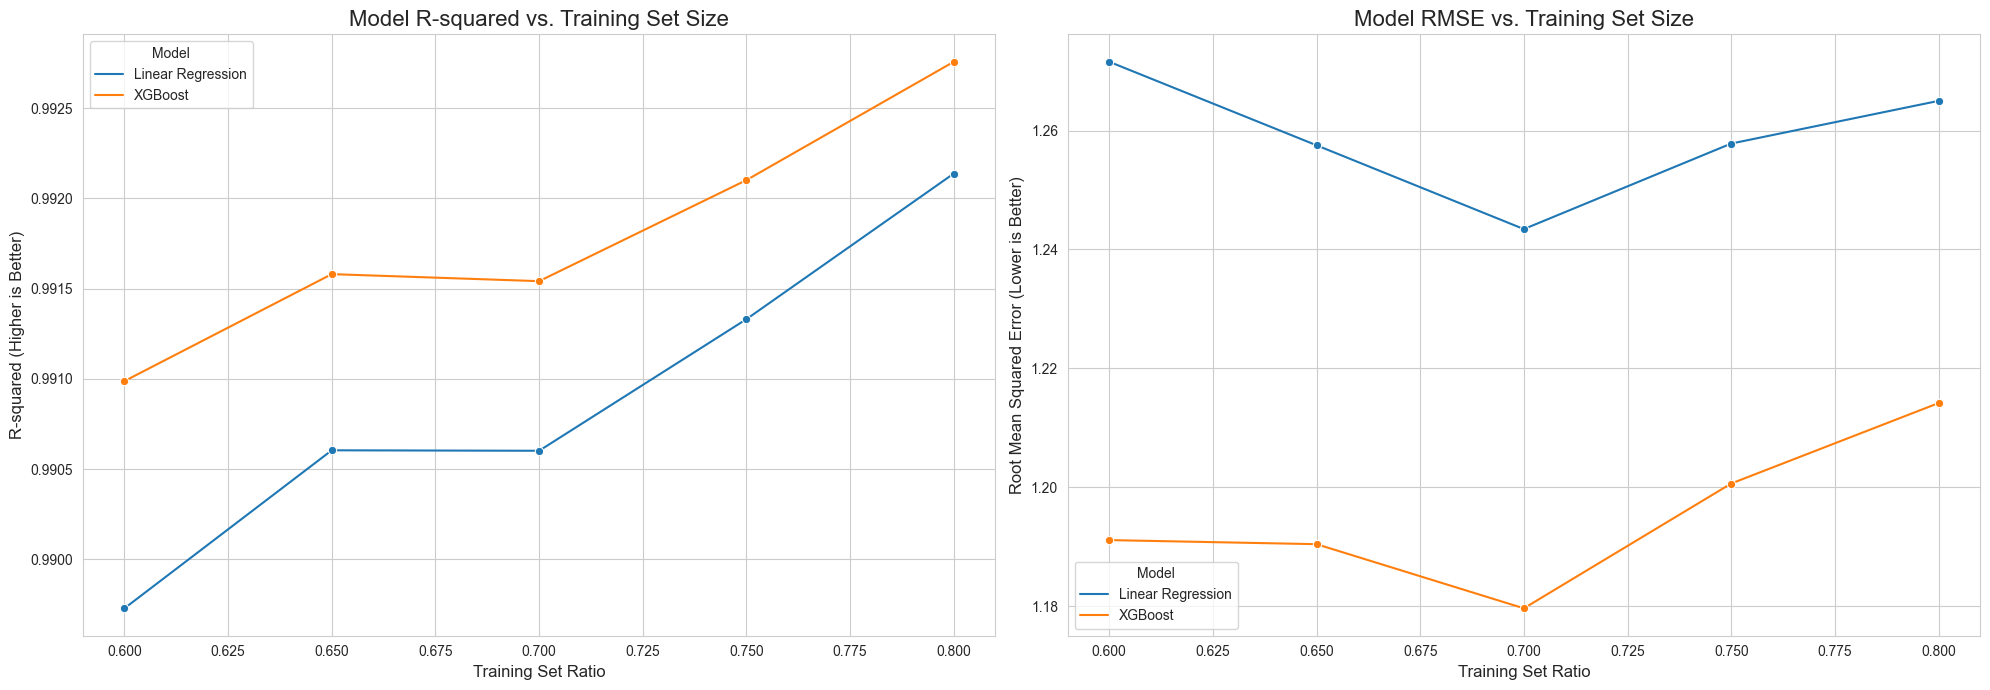

In [ ]:
# --- 6. PERFORMANCE ANALYSIS VS. TRAINING SIZE (EXPANDED) ---
print("\n--- 6. Performance Analysis vs. Training Size ---")

# Convert the log into a DataFrame
# This DataFrame now contains all the calculated metrics
results_df_log = pd.DataFrame(results_log)

# Ensure the column names here match the keys in your results_log dictionary
# Expected columns: 'split_ratio', 'model', 'r_squared', 'adjusted_r_squared', 'rmse', 'mae', 'medae', 'mape'

# --- Create a 2x3 grid of subplots for a comprehensive view ---
fig, axes = plt.subplots(2, 3, figsize=(24, 14))
fig.suptitle('Comprehensive Model Performance Analysis vs. Training Size', fontsize=20, fontweight='bold')

# --- Plot 1: R-squared (Original) ---
sns.lineplot(data=results_df_log, x='split_ratio', y='r_squared', hue='model', marker='o', ax=axes[0, 0])
axes[0, 0].set_title('R-squared vs. Training Set Size', fontsize=16)
axes[0, 0].set_xlabel('Training Set Ratio', fontsize=12)
axes[0, 0].set_ylabel('R-squared (Higher is Better)', fontsize=12)
axes[0, 0].legend(title='Model')
axes[0, 0].grid(True, which='both', linestyle='--', linewidth=0.5)

# --- Plot 2: Adjusted R-squared (NEW) ---
sns.lineplot(data=results_df_log, x='split_ratio', y='adjusted_r_squared', hue='model', marker='o', ax=axes[0, 1])
axes[0, 1].set_title('Adjusted R-squared vs. Training Set Size', fontsize=16)
axes[0, 1].set_xlabel('Training Set Ratio', fontsize=12)
axes[0, 1].set_ylabel('Adjusted R-squared (Higher is Better)', fontsize=12)
axes[0, 1].legend(title='Model')
axes[0, 1].grid(True, which='both', linestyle='--', linewidth=0.5)

# --- Plot 3: Mean Absolute Percentage Error (MAPE) (NEW) ---
sns.lineplot(data=results_df_log, x='split_ratio', y='mape', hue='model', marker='o', ax=axes[0, 2])
axes[0, 2].set_title('MAPE vs. Training Set Size', fontsize=16)
axes[0, 2].set_xlabel('Training Set Ratio', fontsize=12)
axes[0, 2].set_ylabel('MAPE (Lower is Better)', fontsize=12)
axes[0, 2].yaxis.set_major_formatter(plt.FuncFormatter('{:.1%}'.format)) # Format y-axis as percentage
axes[0, 2].legend(title='Model')
axes[0, 2].grid(True, which='both', linestyle='--', linewidth=0.5)

# --- Plot 4: Root Mean Squared Error (RMSE) (Original) ---
sns.lineplot(data=results_df_log, x='split_ratio', y='rmse', hue='model', marker='o', ax=axes[1, 0])
axes[1, 0].set_title('RMSE vs. Training Set Size', fontsize=16)
axes[1, 0].set_xlabel('Training Set Ratio', fontsize=12)
axes[1, 0].set_ylabel('RMSE (Lower is Better)', fontsize=12)
axes[1, 0].legend(title='Model')
axes[1, 0].grid(True, which='both', linestyle='--', linewidth=0.5)

# --- Plot 5: Mean Absolute Error (MAE) (NEW) ---
sns.lineplot(data=results_df_log, x='split_ratio', y='mae', hue='model', marker='o', ax=axes[1, 1])
axes[1, 1].set_title('MAE vs. Training Set Size', fontsize=16)
axes[1, 1].set_xlabel('Training Set Ratio', fontsize=12)
axes[1, 1].set_ylabel('MAE (Lower is Better)', fontsize=12)
axes[1, 1].legend(title='Model')
axes[1, 1].grid(True, which='both', linestyle='--', linewidth=0.5)

# --- Plot 6: Median Absolute Error (MedAE) (NEW) ---
sns.lineplot(data=results_df_log, x='split_ratio', y='medae', hue='model', marker='o', ax=axes[1, 2])
axes[1, 2].set_title('Median Absolute Error vs. Training Set Size', fontsize=16)
axes[1, 2].set_xlabel('Training Set Ratio', fontsize=12)
axes[1, 2].set_ylabel('MedAE (Lower is Better)', fontsize=12)
axes[1, 2].legend(title='Model')
axes[1, 2].grid(True, which='both', linestyle='--', linewidth=0.5)


# Adjust layout to prevent titles from overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96]) # rect leaves space for suptitle
plt.show()


--- 7. Feature Importance Analysis (Final XGBoost Model) ---


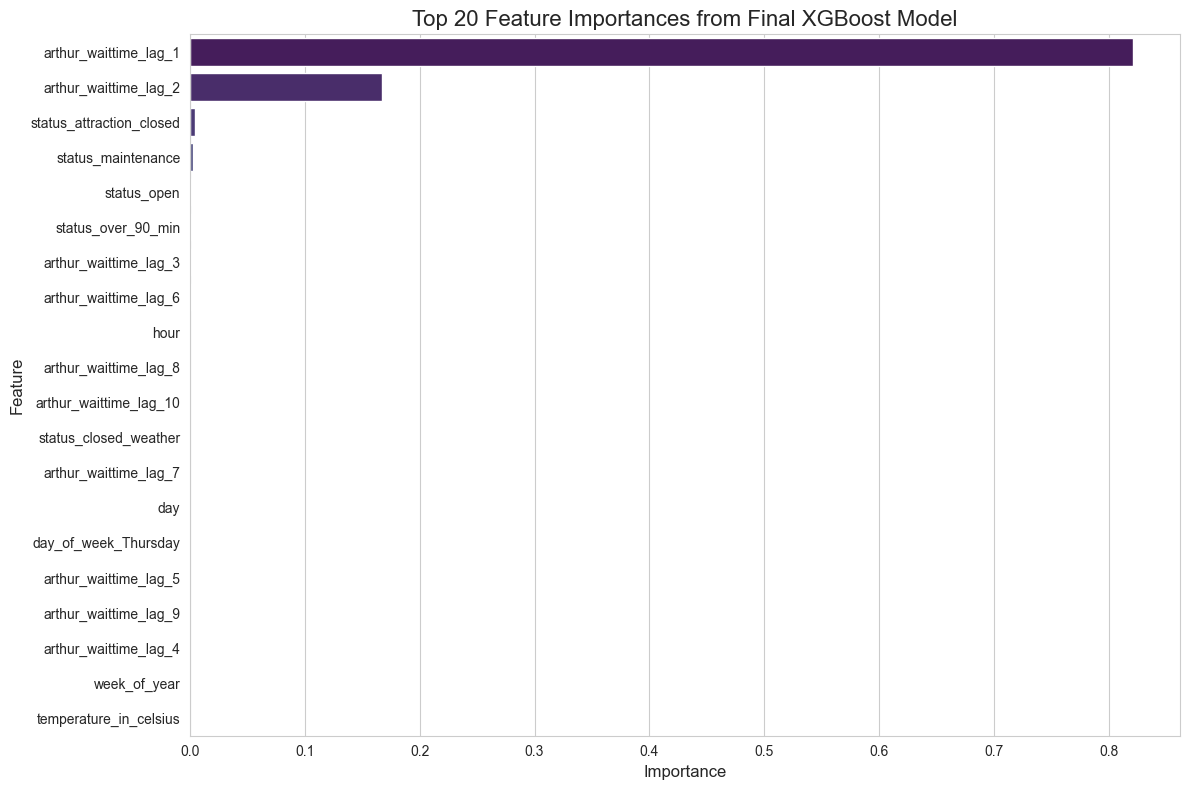

In [416]:
# --- 7. DETAILED ANALYSIS OF FINAL MODEL ---
print("\n--- 7. Feature Importance Analysis (Final XGBoost Model) ---")

feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': final_xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(20) # Top 20 features

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
plt.title('Top 20 Feature Importances from Final XGBoost Model', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()





--- 8. Visualize Predictions of Final Models ---


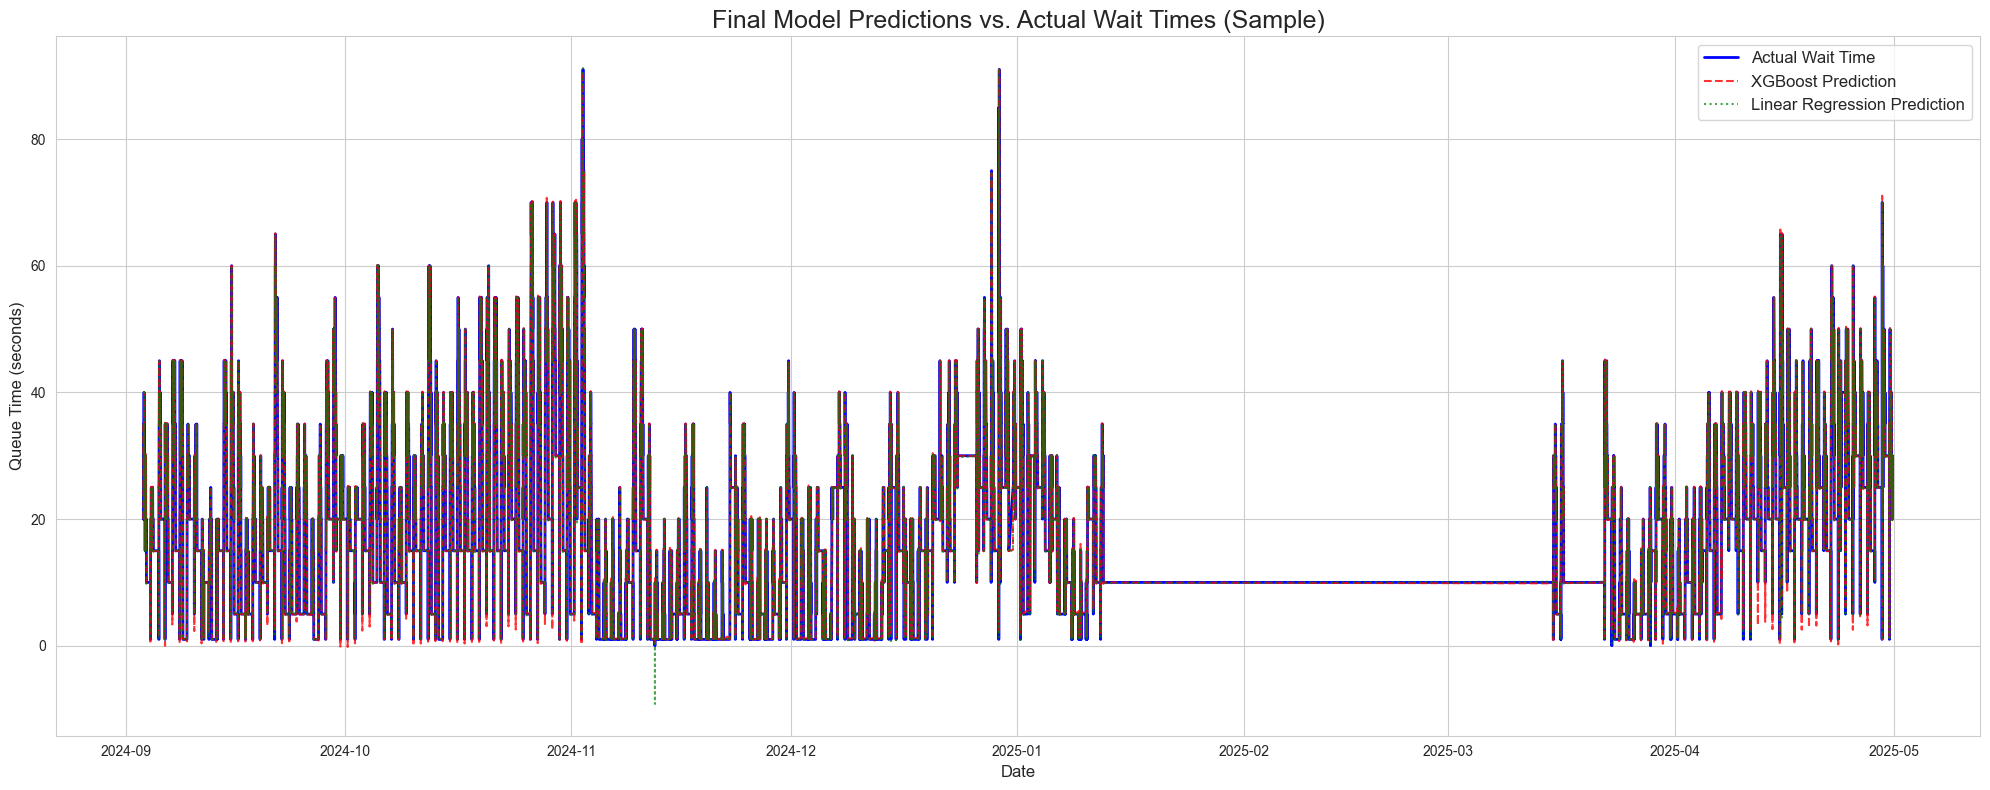

In [ ]:
# VISUALIZE PREDICTIONS (FINAL MODEL) 
print("\n Visualize Predictions of Final Models")

# Get predictions from the final models
final_lr_preds = final_lr_model.predict(final_X_test)
final_xgb_preds = final_xgb_model.predict(final_X_test)

# Create a dataframe for easy plotting
final_results_df = pd.DataFrame({
    'date': final_test_dates,
    'actual_wait_time': final_y_test,
    'xgb_predicted_time': final_xgb_preds,
    'lr_predicted_time': final_lr_preds
})

# Plot a sample of the results (e.g., the first 500 test points) to keep it readable
plt.figure(figsize=(20, 8))
plt.plot(final_results_df['date'], final_results_df['actual_wait_time'], label='Actual Wait Time', color='blue', linewidth=2)
plt.plot(final_results_df['date'], final_results_df['xgb_predicted_time'], label='XGBoost Prediction', color='red', linestyle='--', alpha=0.8)
plt.plot(final_results_df['date'], final_results_df['lr_predicted_time'], label='Linear Regression Prediction', color='green', linestyle=':', alpha=0.7)
plt.title('Final Model Predictions vs. Actual Wait Times (Sample)', fontsize=18)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Queue Time (seconds)', fontsize=12)
plt.legend(fontsize=12)
plt.show()


Plotting the first 500 data points of the test set...


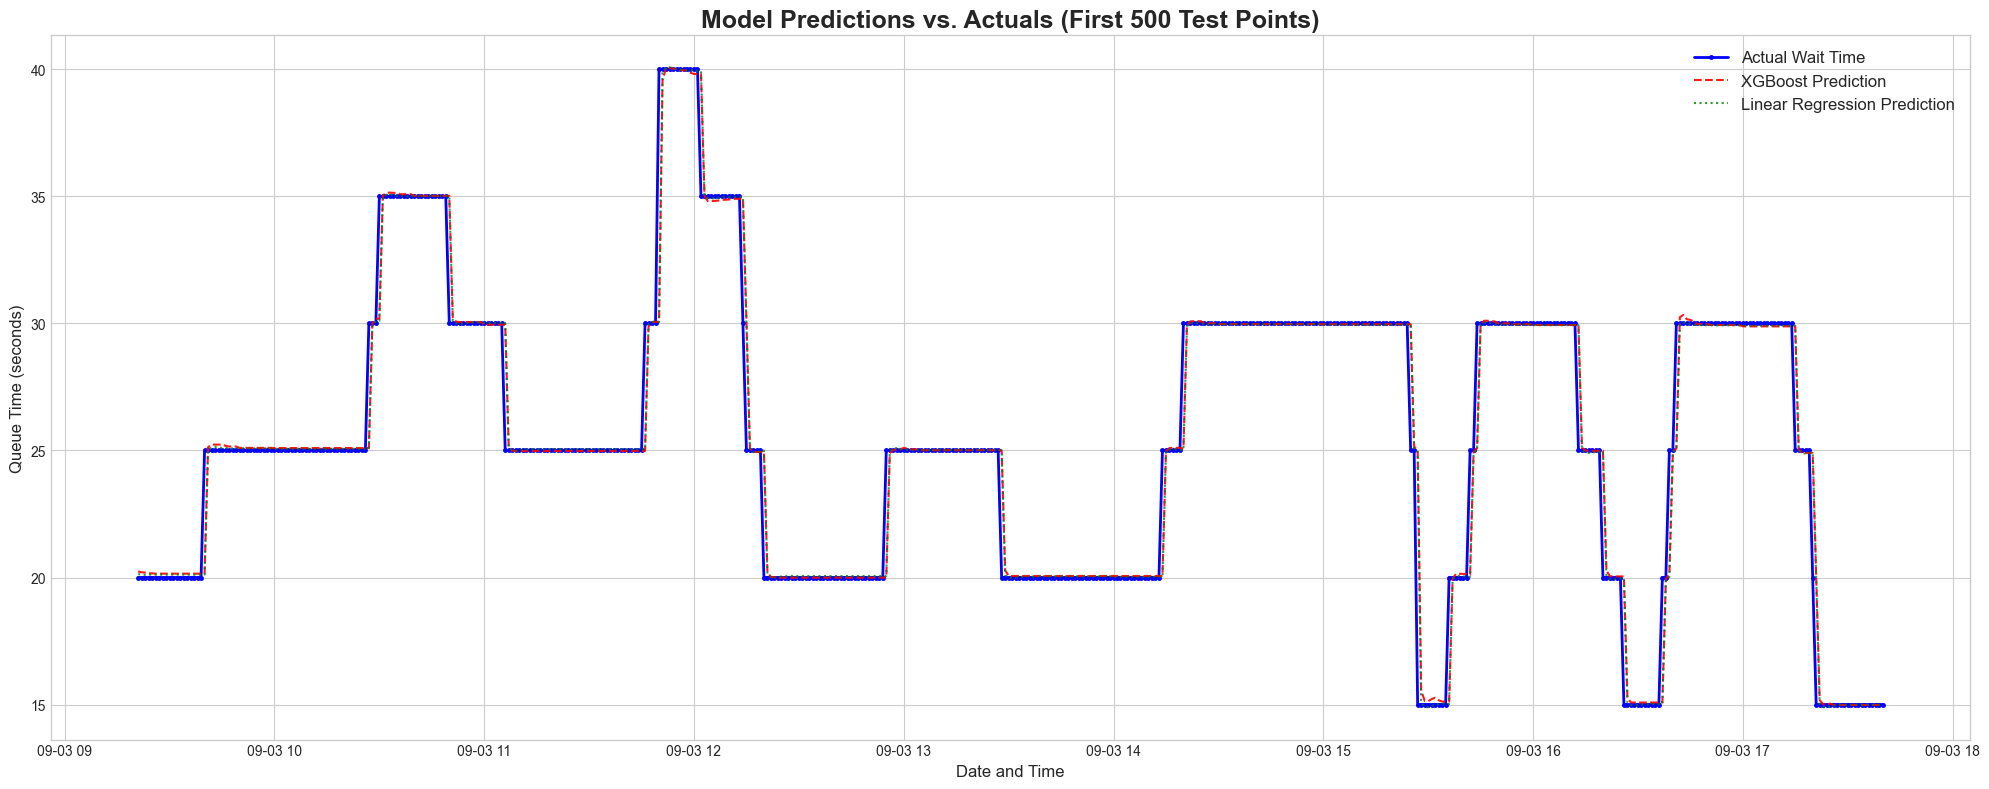

Plotting the middle 500 data points of the test set...


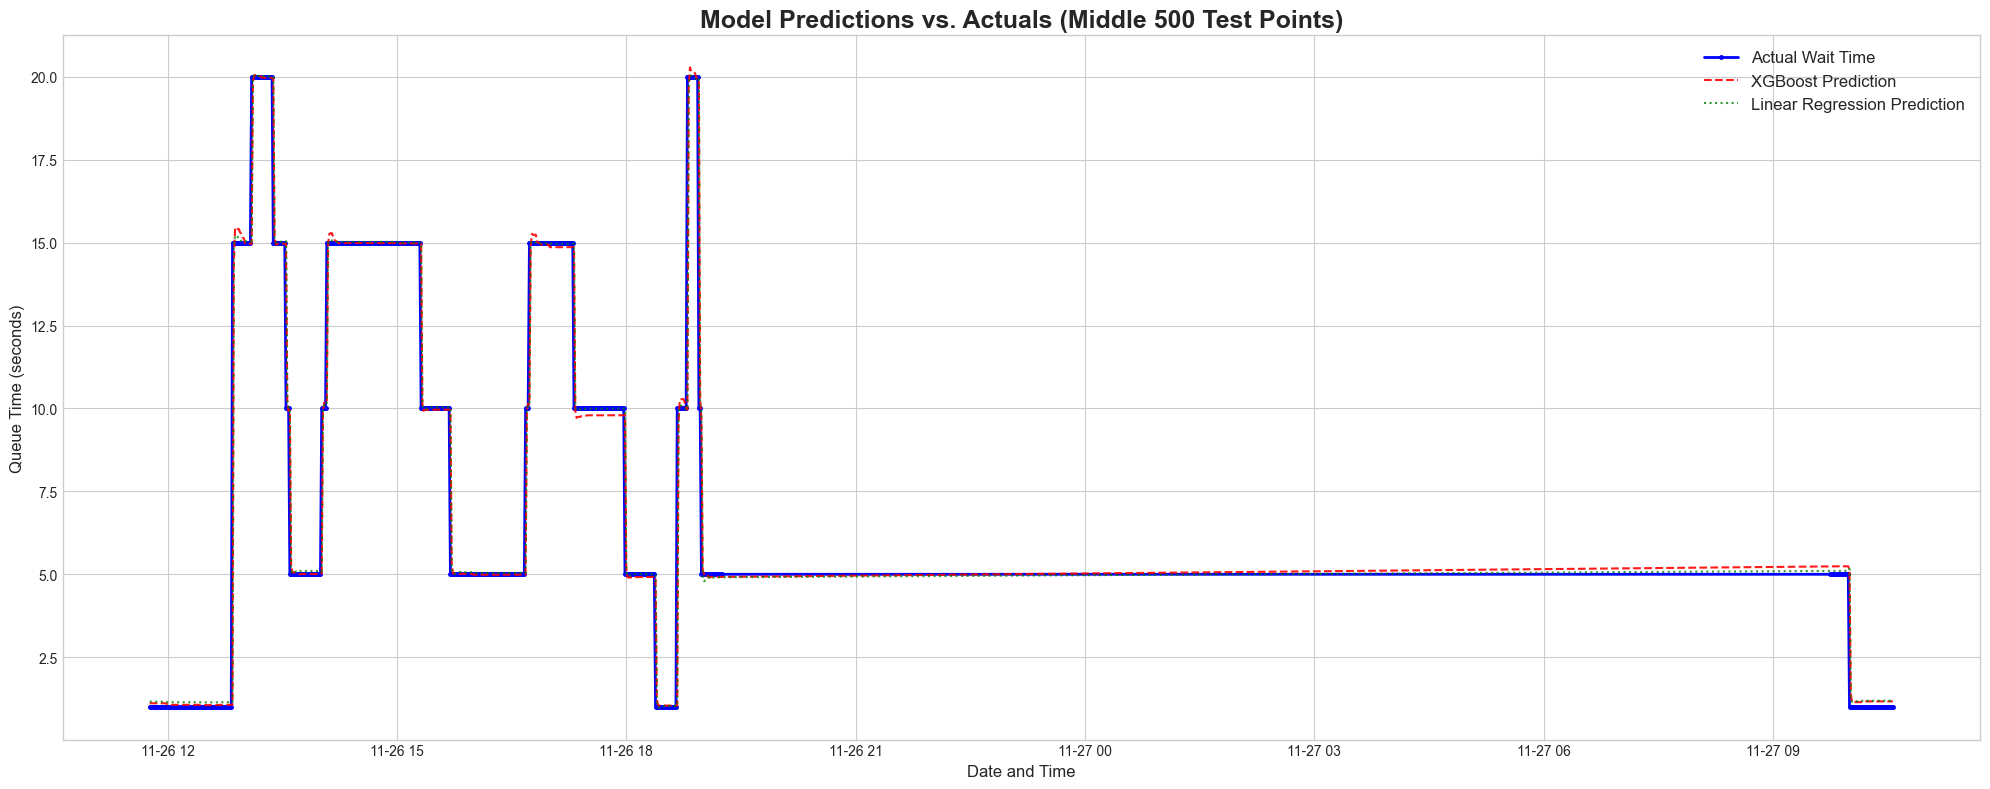

Plotting the last 500 data points of the test set...


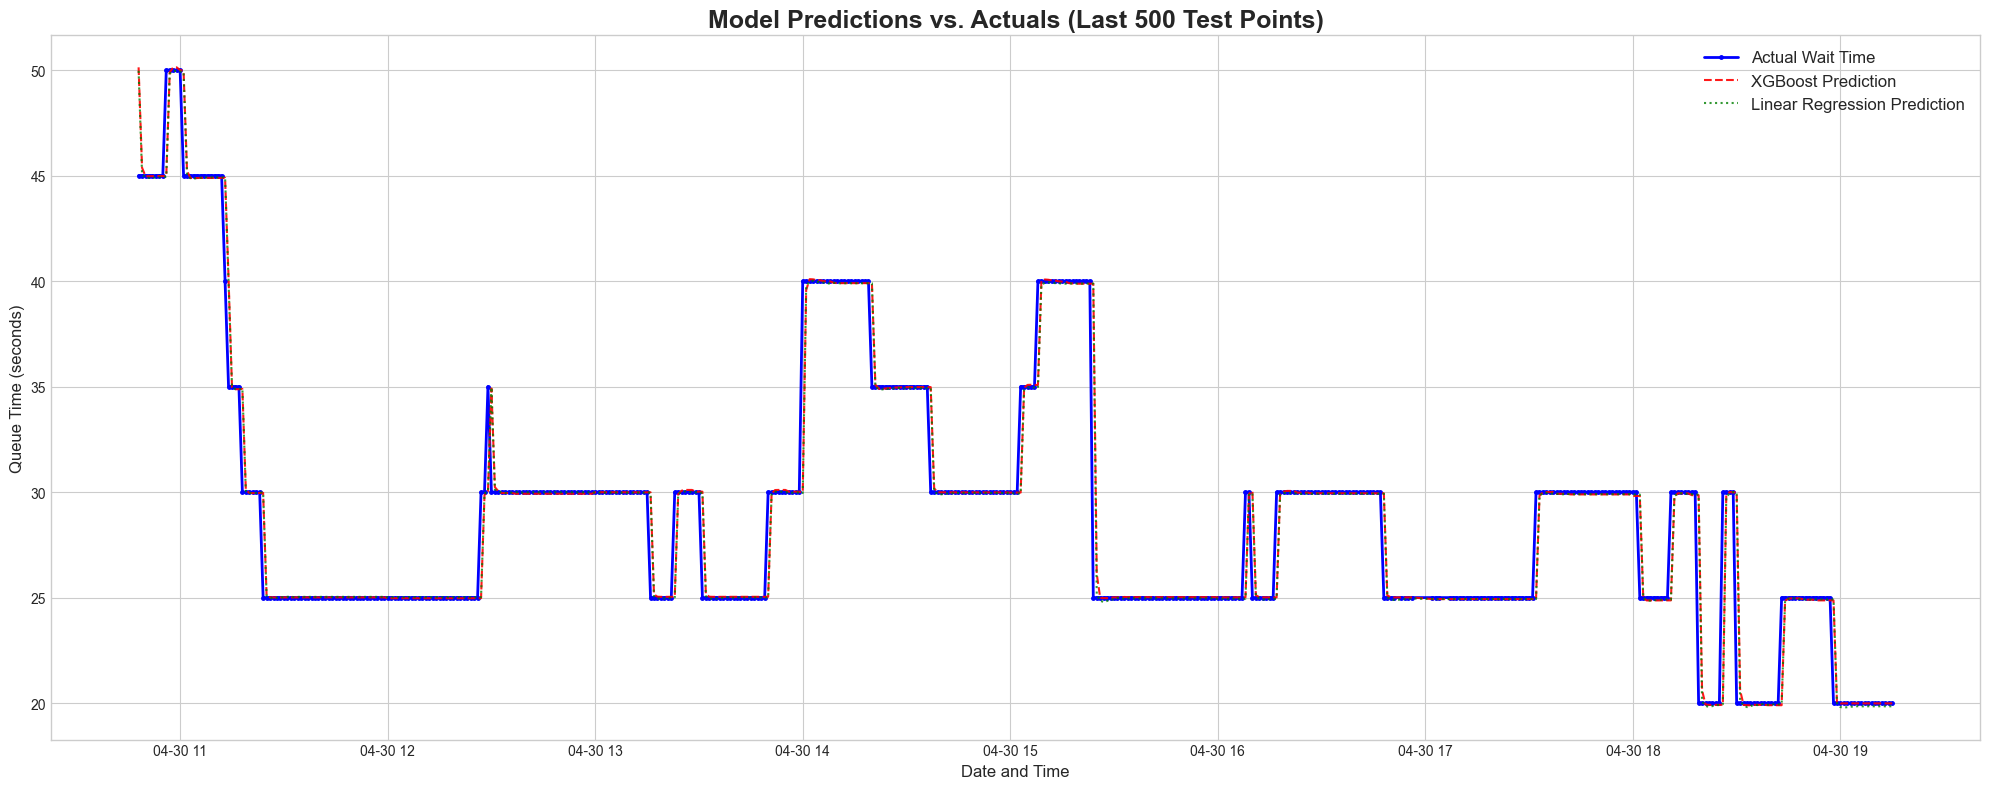

In [421]:
# Plot first, middle, and last 500 points of the test set.
# =============================================================================
def plot_data_slice(df_slice, title_text):
    """Plots a slice of the results DataFrame."""
    if df_slice.empty:
        print(f"Warning: The slice for '{title_text}' is empty. Skipping plot.")
        return

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(20, 8))
    plt.plot(df_slice['date'], df_slice['actual_wait_time'], label='Actual Wait Time', color='blue', linewidth=2, marker='.', markersize=5)
    plt.plot(df_slice['date'], df_slice['xgb_predicted_time'], label='XGBoost Prediction', color='red', linestyle='--', alpha=0.9)
    plt.plot(df_slice['date'], df_slice['lr_predicted_time'], label='Linear Regression Prediction', color='green', linestyle=':', alpha=0.8)
    
    plt.title(title_text, fontsize=18, fontweight='bold')
    plt.xlabel('Date and Time', fontsize=12)
    plt.ylabel('Queue Time (seconds)', fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Define the slice size and plot
N = 500
total_test_rows = len(final_results_df)

# Plot 1: First 500 Data Points
print(f"\nPlotting the first {N} data points of the test set...")
plot_data_slice(final_results_df.iloc[:N], f'Model Predictions vs. Actuals (First {N} Test Points)')

# Plot 2: Middle 500 Data Points
middle_point = total_test_rows // 2
start_index = middle_point - (N // 2)
end_index = middle_point + (N // 2)
print(f"Plotting the middle {N} data points of the test set...")
plot_data_slice(final_results_df.iloc[start_index:end_index], f'Model Predictions vs. Actuals (Middle {N} Test Points)')

# Plot 3: Last 500 Data Points
print(f"Plotting the last {N} data points of the test set...")
plot_data_slice(final_results_df.iloc[-N:], f'Model Predictions vs. Actuals (Last {N} Test Points)')


#### Next steps: 
#### Hyperparameter Tuning: Use techniques like GridSearchCV or RandomizedSearchCV to find the optimal parameters for the XGBoost model, which can further improve its performance.
#### Create More Features: Engineer more sophisticated features, such as rolling averages of wait times or the time elapsed since the park opened.